In [1]:
import sys
sys.path.append("../src")

In [2]:
from utils.load_model import get_model

from my_model import get_ilsvrc2012

from torch.utils.data import DataLoader

from utils.imagenet1000_classname import imgnet_label_name
from utils.tensortracker import TensorTracker
from utils import plots

In [3]:
%matplotlib inline

In [4]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch.nn as nn

import svcca

In [5]:
mode = "test"
test_dataset = get_ilsvrc2012(mode=mode, transform_type="test")
test_labels = np.asarray(test_dataset.targets)

In [6]:
index = []
for i in range(1000):
    idx = np.where(test_labels == i)[0][0]
    index.append(idx)
index = np.asarray(index)

In [7]:
np.unique(test_labels[index]).shape

(1000,)

In [8]:
device = "cuda"
N = 256
np.random.seed(815)
perm = np.random.permutation(len(index))
images = [test_dataset[i][0] for i in index[perm[:N]]]
images = torch.stack(images)
images = images.to(device)

In [9]:
names = [
    "resnet34-skip",
    "resnet34-skip2",
    "resnet34-plain",
    "resnet34-plain2",
]

trackers = {}

for name in names:
    model = get_model(name)
    model = model.eval()
    model = model.to(device)

    tracker = TensorTracker(model)
    with torch.no_grad():
        out = model.layer_forward(images)
    trackers[name] = tracker

In [10]:
keys_skip = trackers["resnet34-skip"].fmap_pool.keys()
keys_plain = trackers["resnet34-plain"].fmap_pool.keys()

In [11]:
set(keys_skip) - set(keys_plain)

{'layer1.0.add_func',
 'layer1.1.add_func',
 'layer1.2.add_func',
 'layer2.0.add_func',
 'layer2.0.downsample',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.1.add_func',
 'layer2.2.add_func',
 'layer2.3.add_func',
 'layer3.0.add_func',
 'layer3.0.downsample',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.1.add_func',
 'layer3.2.add_func',
 'layer3.3.add_func',
 'layer3.4.add_func',
 'layer3.5.add_func',
 'layer4.0.add_func',
 'layer4.0.downsample',
 'layer4.0.downsample.0',
 'layer4.0.downsample.1',
 'layer4.1.add_func',
 'layer4.2.add_func'}

In [12]:
def calc_mean_svcca(tracker1, tracker2, layers1, layers2, epsilon=0, skip_mode=False):
    table = np.zeros((len(layers1), len(layers2)))
    for cnt1, l1 in tqdm(enumerate(layers1), total=len(layers1)):
        for cnt2, l2 in enumerate(layers2):
            if skip_mode:
                if cnt1 > cnt2:
                    continue
            act1 = tracker1.find_fmap(l1).to('cpu').numpy()
            act1 = np.transpose(act1, (1, 0, 2, 3))
            act1 = act1.reshape(len(act1), -1).astype(np.float64)

            act2 = tracker2.find_fmap(l2).to('cpu').numpy()
            act2 = np.transpose(act2, (1, 0, 2, 3))
            act2 = act2.reshape(len(act2), -1).astype(np.float64)
            try:
                result = svcca.cca_core.get_cca_similarity(act1, act2, epsilon=epsilon, verbose=False)
                value = sum(result["mean"]) / 2
            except:
                value = 0
            table[cnt1, cnt2] = value
    return table

In [13]:
def show_pack(table, layers1, layers2):
    plt.figure(figsize=(10, 10))
    plt.imshow(table, vmin=0, vmax=1)
    plt.yticks(range(len(layers1)), layers1)
    plt.xticks(range(len(layers2)), layers2, rotation=90)
    plt.show()

    index = np.argsort(table[0, :])

    plt.figure(figsize=(8, 6))
    plt.plot(table[0, index])
    plt.ylim(0, 1)
    plt.xticks(range(len(layers2)), np.asarray(layers2)[index], rotation=90)
    plt.grid()
    plt.show()
    
    index = np.argsort(table[-1, :])

    plt.figure(figsize=(8, 6))
    plt.plot(table[-1, index])
    plt.ylim(0, 1)
    plt.xticks(range(len(layers2)), np.asarray(layers2)[index], rotation=90)
    plt.grid()
    plt.show()

In [14]:
keys = trackers["resnet34-skip"].fmap_pool.keys()

_key = "layer1"

def get_layers_keys(_key, keys):
    if _key == "layer1":
        layers = ["maxpool"]
    else:
        layers = []
    layers = layers + [k for k in keys if _key in k  and "downsample" not in k]
    layers = list(filter(lambda x: x not in [_key + "." + str(i) for i in range(10)] + [_key], layers))
    return layers

In [15]:
from itertools import combinations

In [16]:
for key1, key2 in combinations(trackers.keys(), 2):
    print(key1, key2)

resnet34-skip resnet34-skip2
resnet34-skip resnet34-plain
resnet34-skip resnet34-plain2
resnet34-skip2 resnet34-plain
resnet34-skip2 resnet34-plain2
resnet34-plain resnet34-plain2


In [17]:
tables = {}
for _layer in tqdm(["layer1", "layer2", "layer3", "layer4"], total=4):
    for key1, key2 in combinations(trackers.keys(), 2):
        comb_key = "{}-vs-{}".format(key1, key2)
#         tqdm.write(comb_key)
        tracker1 = trackers[key1]
        layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
        tracker2 = trackers[key2]
        layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())
        tables[comb_key+_layer] = calc_mean_svcca(tracker1, tracker2, layers1, layers2)

100%|██████████| 4/4 [2:27:32<00:00, 2214.11s/it]A


In [18]:
tables.keys()

dict_keys(['resnet34-skip-vs-resnet34-skip2layer1', 'resnet34-skip-vs-resnet34-plainlayer1', 'resnet34-skip-vs-resnet34-plain2layer1', 'resnet34-skip2-vs-resnet34-plainlayer1', 'resnet34-skip2-vs-resnet34-plain2layer1', 'resnet34-plain-vs-resnet34-plain2layer1', 'resnet34-skip-vs-resnet34-skip2layer2', 'resnet34-skip-vs-resnet34-plainlayer2', 'resnet34-skip-vs-resnet34-plain2layer2', 'resnet34-skip2-vs-resnet34-plainlayer2', 'resnet34-skip2-vs-resnet34-plain2layer2', 'resnet34-plain-vs-resnet34-plain2layer2', 'resnet34-skip-vs-resnet34-skip2layer3', 'resnet34-skip-vs-resnet34-plainlayer3', 'resnet34-skip-vs-resnet34-plain2layer3', 'resnet34-skip2-vs-resnet34-plainlayer3', 'resnet34-skip2-vs-resnet34-plain2layer3', 'resnet34-plain-vs-resnet34-plain2layer3', 'resnet34-skip-vs-resnet34-skip2layer4', 'resnet34-skip-vs-resnet34-plainlayer4', 'resnet34-skip-vs-resnet34-plain2layer4', 'resnet34-skip2-vs-resnet34-plainlayer4', 'resnet34-skip2-vs-resnet34-plain2layer4', 'resnet34-plain-vs-resne

In [19]:
table = tables["resnet34-skip-vs-resnet34-skip2layer1"].copy()

In [20]:
table.shape

(22, 22)

In [21]:
table = tables["resnet34-skip-vs-resnet34-skip2layer1"].copy() - tables["resnet34-skip-vs-resnet34-skip2layer1"].copy().T

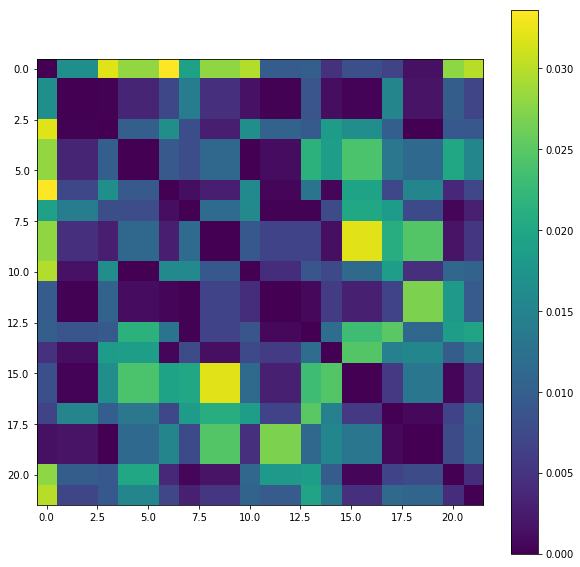

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(table))
plt.colorbar()
plt.show()

In [23]:
table = tables["resnet34-skip-vs-resnet34-plainlayer1"].copy()

In [24]:
table.shape

(22, 19)

In [25]:
table[0, 1] - table[1, 0]

0.042851321906950735

resnet34-skip-vs-resnet34-skip2layer1


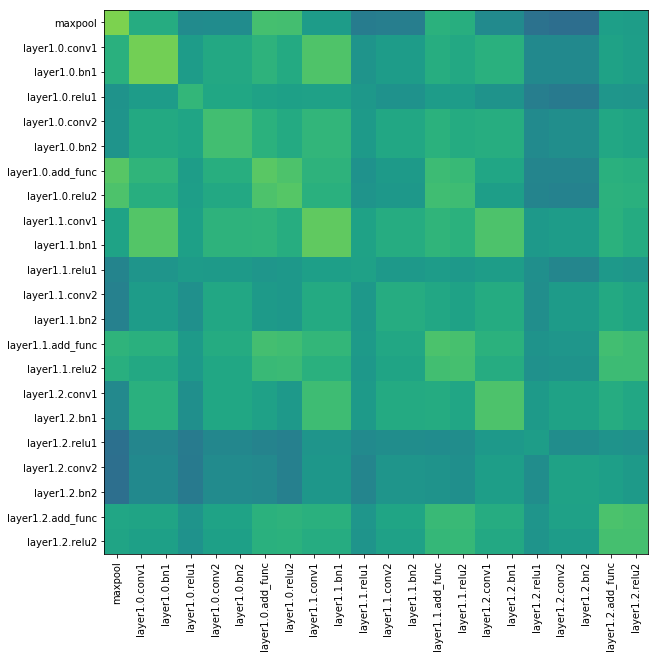

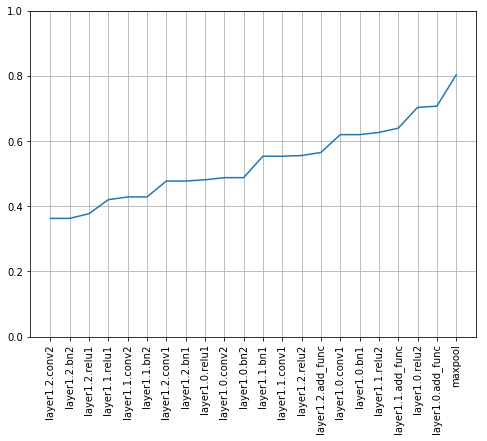

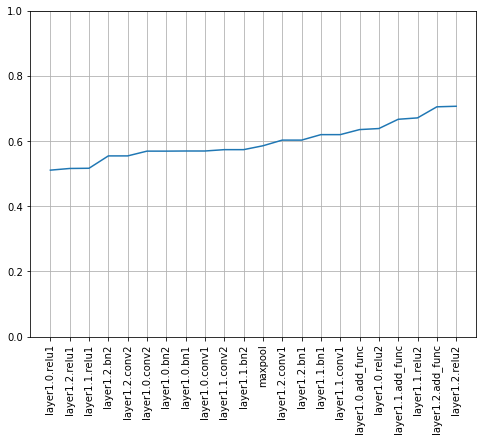

resnet34-skip-vs-resnet34-plainlayer1


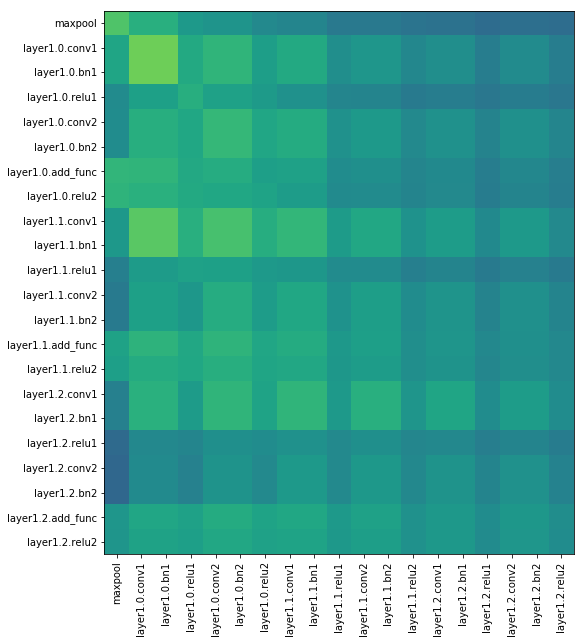

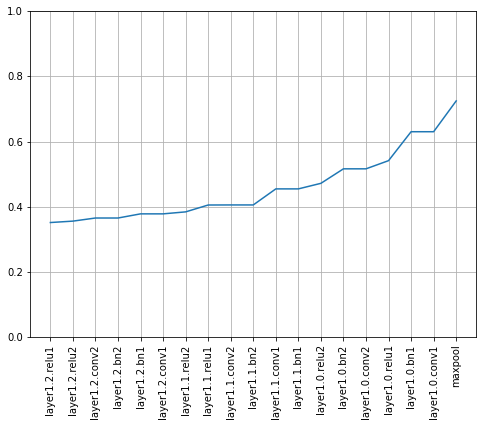

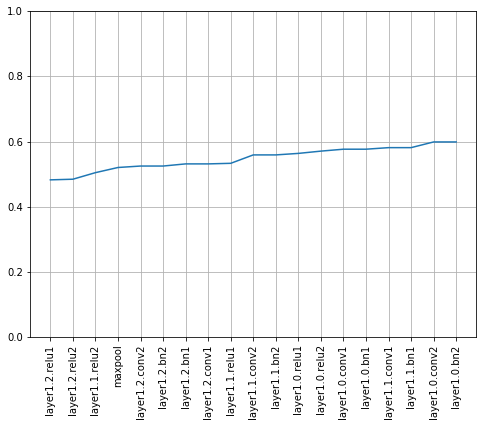

resnet34-skip-vs-resnet34-plain2layer1


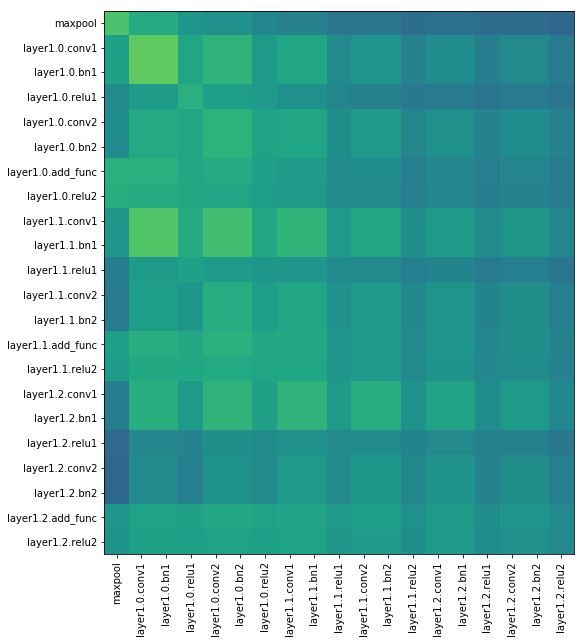

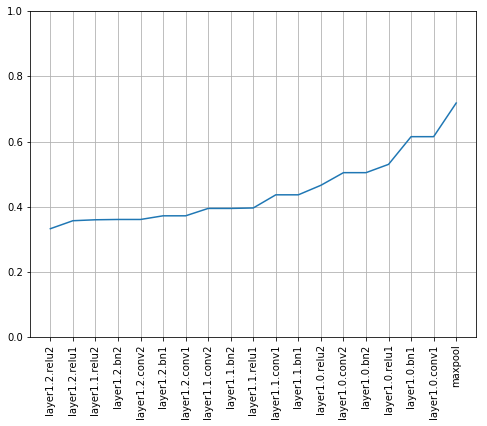

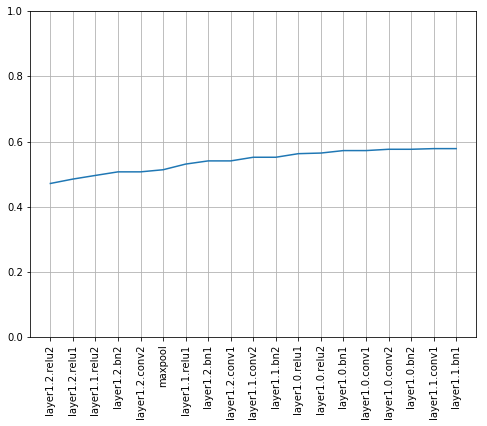

resnet34-skip2-vs-resnet34-plainlayer1


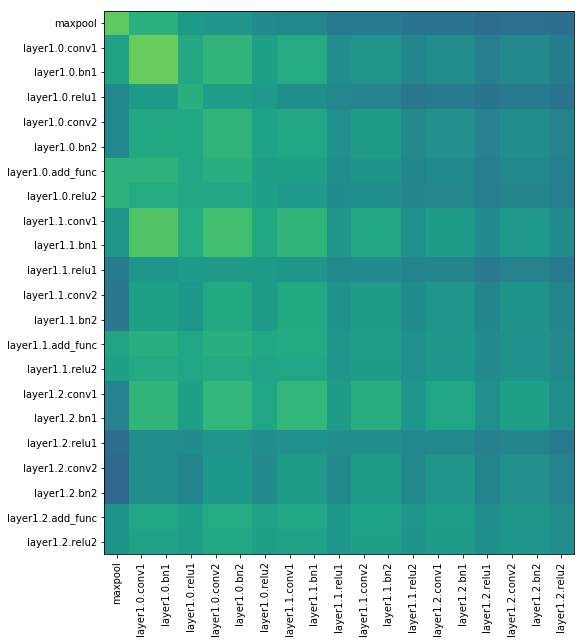

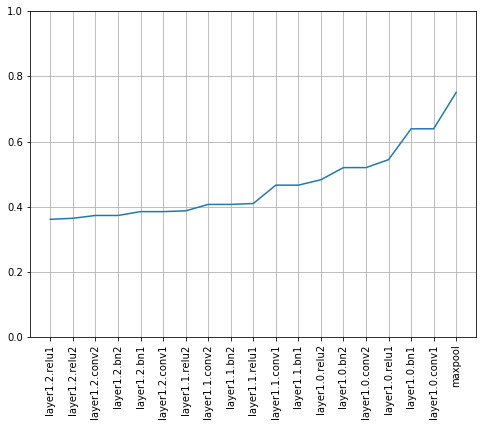

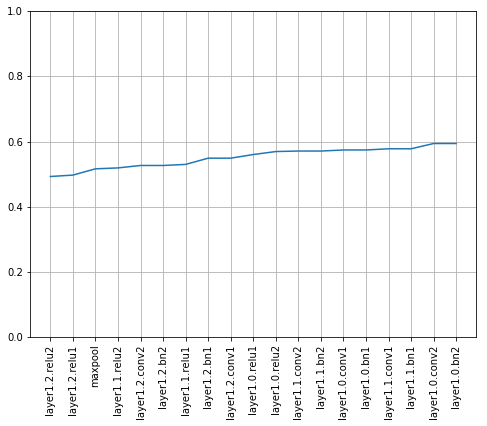

resnet34-skip2-vs-resnet34-plain2layer1


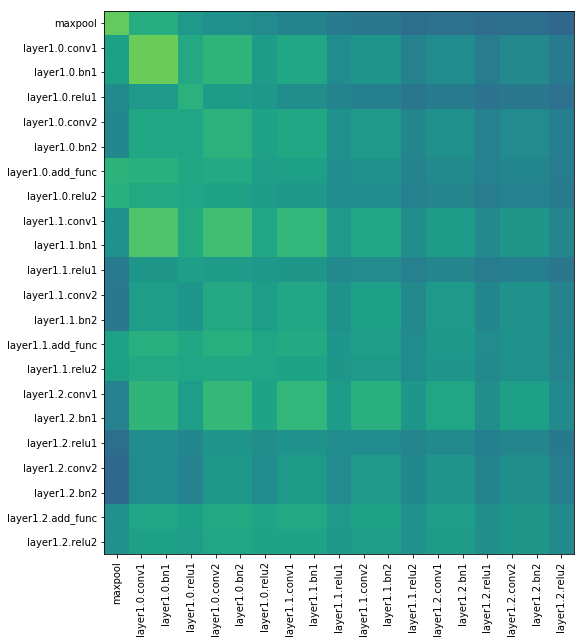

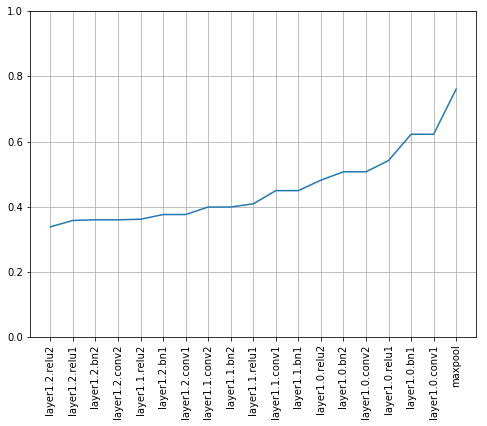

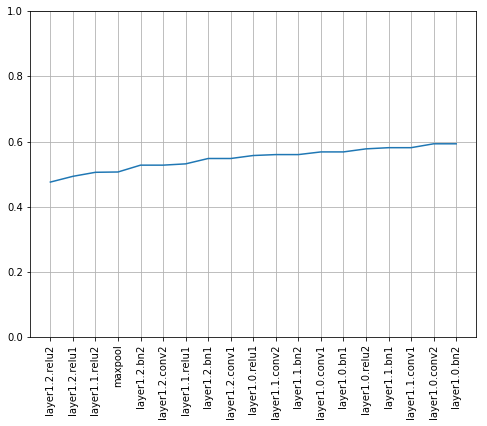

resnet34-plain-vs-resnet34-plain2layer1


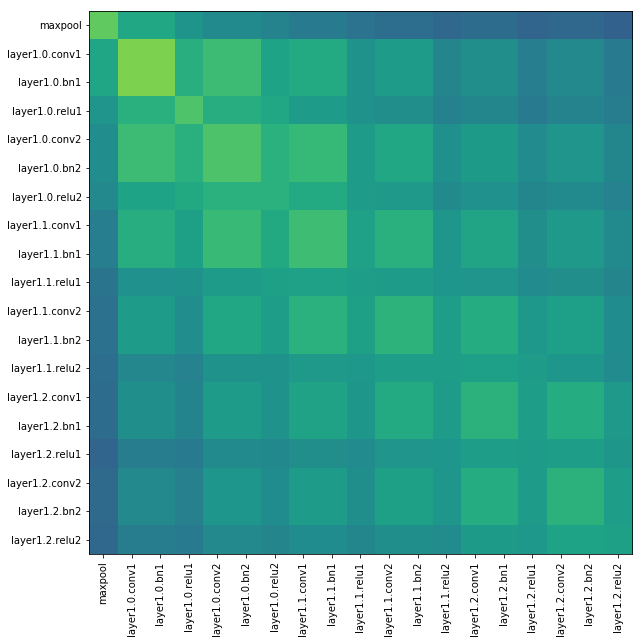

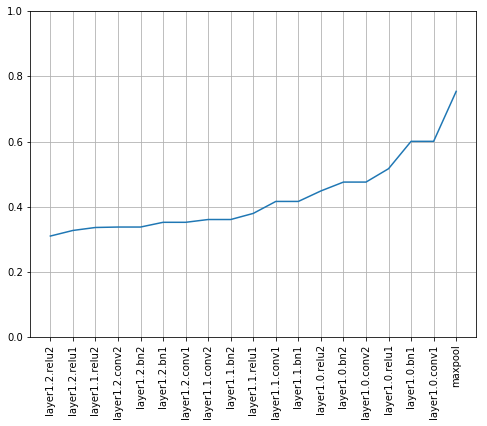

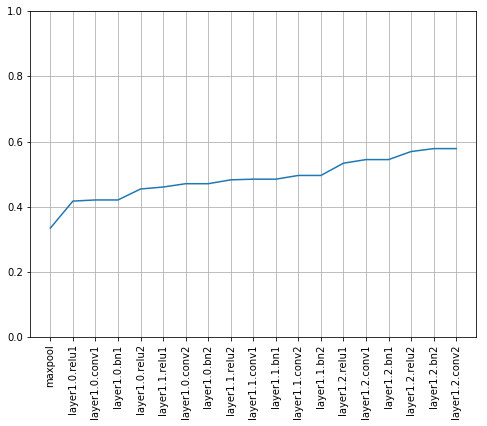

In [27]:
_layer = "layer1"
for key1, key2 in combinations(trackers.keys(), 2):
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    print(comb_key)
    table = tables[comb_key].copy()

    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    tracker2 = trackers[key2]
    layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())

    show_pack(table, layers1, layers2)

In [28]:
import pickle

In [30]:
path = "20200815/svcca_mean_tables.pkl"
with open(path, "wb") as f:
    pickle.dump(tables, f)

In [31]:
tables.keys()

dict_keys(['resnet34-skip-vs-resnet34-skip2layer1', 'resnet34-skip-vs-resnet34-plainlayer1', 'resnet34-skip-vs-resnet34-plain2layer1', 'resnet34-skip2-vs-resnet34-plainlayer1', 'resnet34-skip2-vs-resnet34-plain2layer1', 'resnet34-plain-vs-resnet34-plain2layer1', 'resnet34-skip-vs-resnet34-skip2layer2', 'resnet34-skip-vs-resnet34-plainlayer2', 'resnet34-skip-vs-resnet34-plain2layer2', 'resnet34-skip2-vs-resnet34-plainlayer2', 'resnet34-skip2-vs-resnet34-plain2layer2', 'resnet34-plain-vs-resnet34-plain2layer2', 'resnet34-skip-vs-resnet34-skip2layer3', 'resnet34-skip-vs-resnet34-plainlayer3', 'resnet34-skip-vs-resnet34-plain2layer3', 'resnet34-skip2-vs-resnet34-plainlayer3', 'resnet34-skip2-vs-resnet34-plain2layer3', 'resnet34-plain-vs-resnet34-plain2layer3', 'resnet34-skip-vs-resnet34-skip2layer4', 'resnet34-skip-vs-resnet34-plainlayer4', 'resnet34-skip-vs-resnet34-plain2layer4', 'resnet34-skip2-vs-resnet34-plainlayer4', 'resnet34-skip2-vs-resnet34-plain2layer4', 'resnet34-plain-vs-resne

resnet34-skip-vs-resnet34-skip2layer2


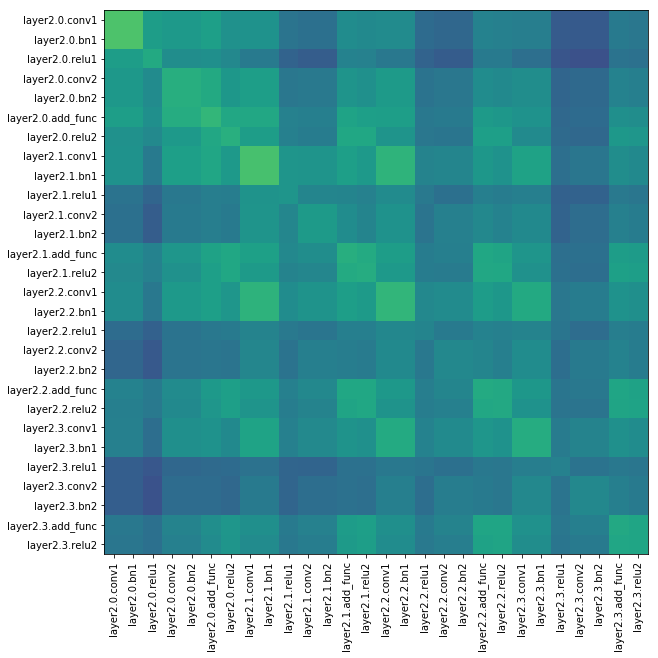

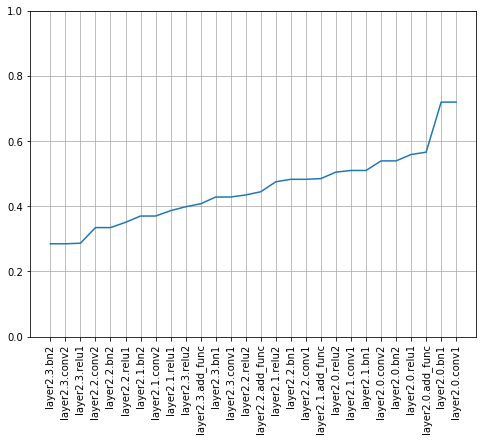

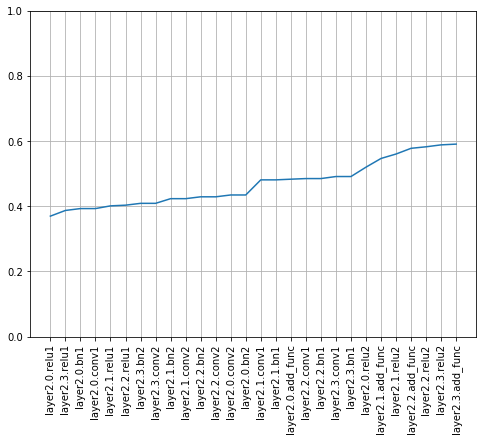

resnet34-skip-vs-resnet34-plainlayer2


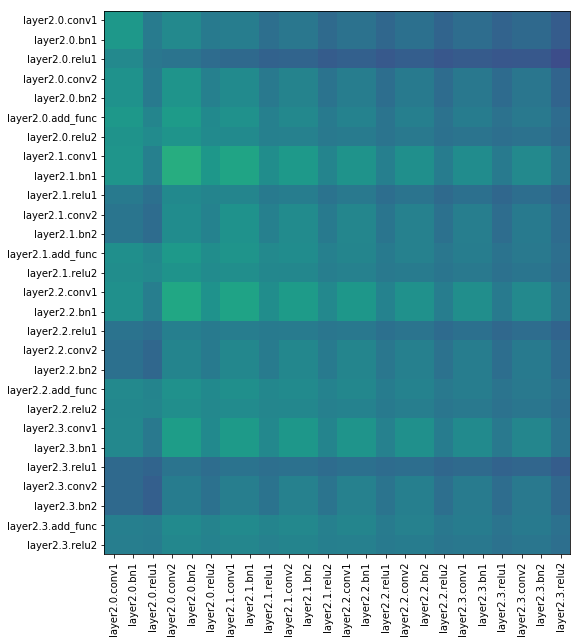

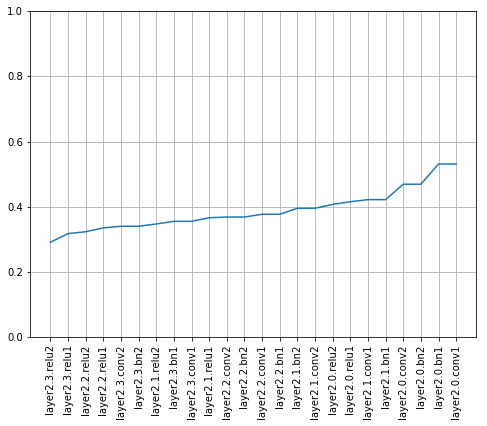

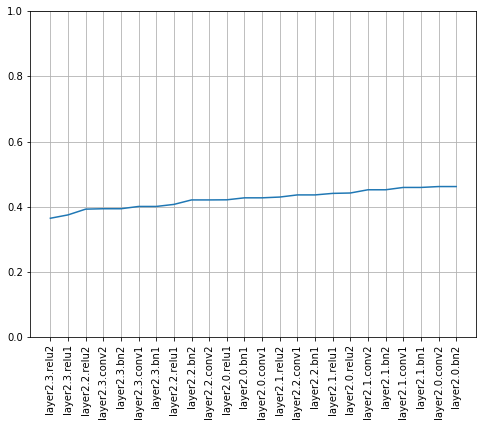

resnet34-skip-vs-resnet34-plain2layer2


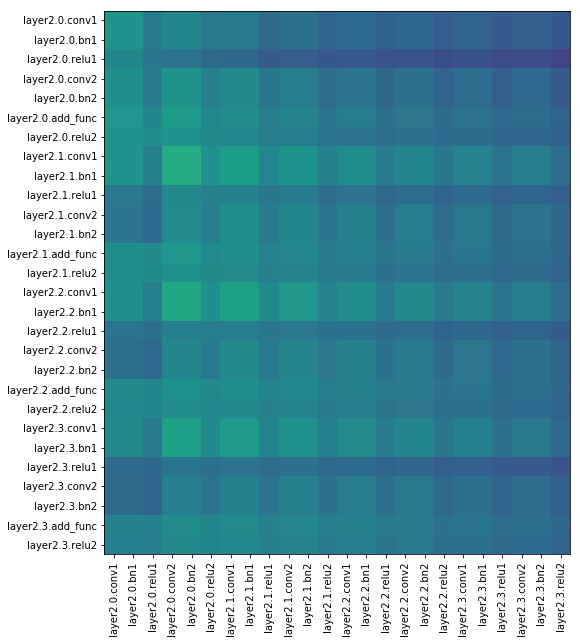

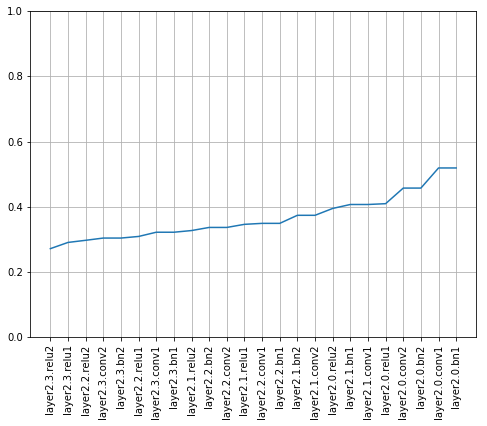

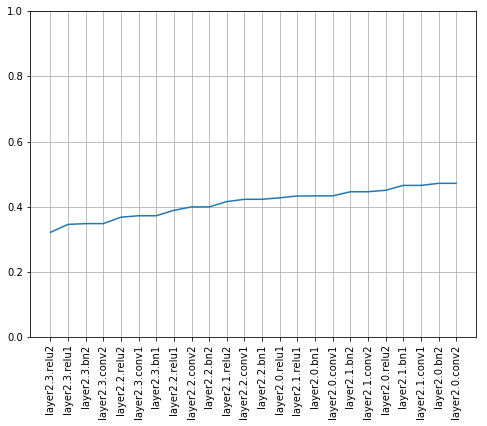

resnet34-skip2-vs-resnet34-plainlayer2


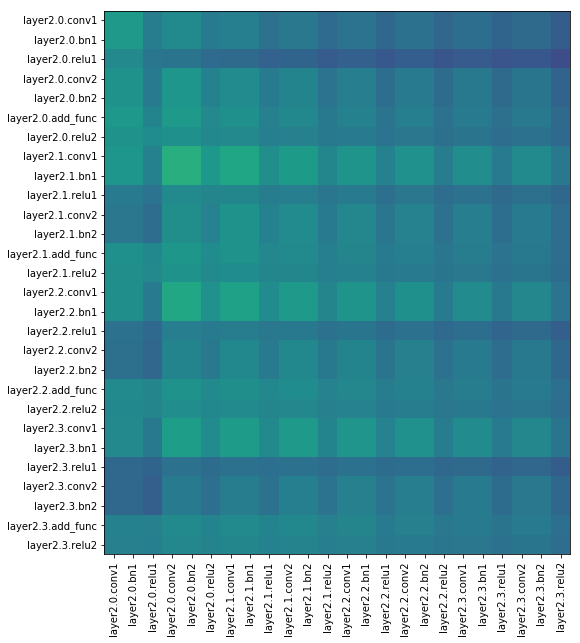

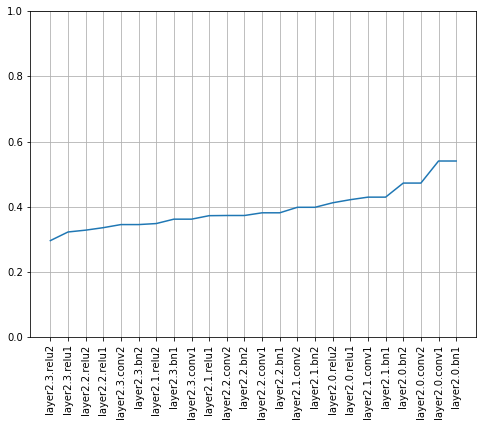

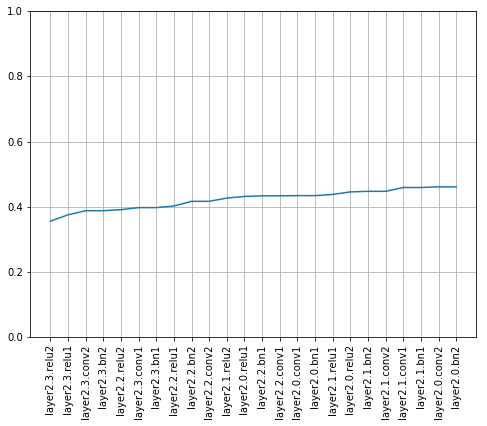

resnet34-skip2-vs-resnet34-plain2layer2


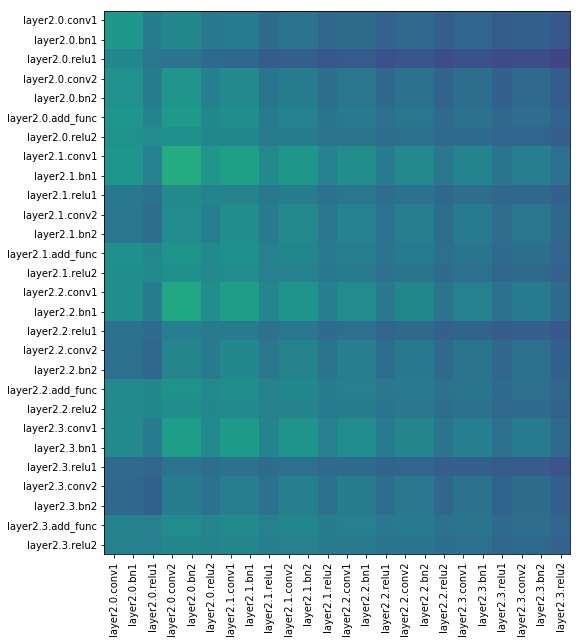

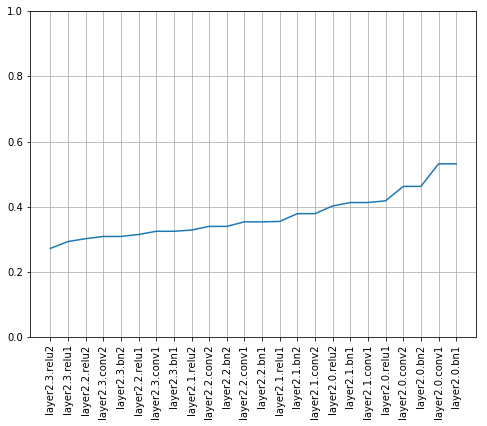

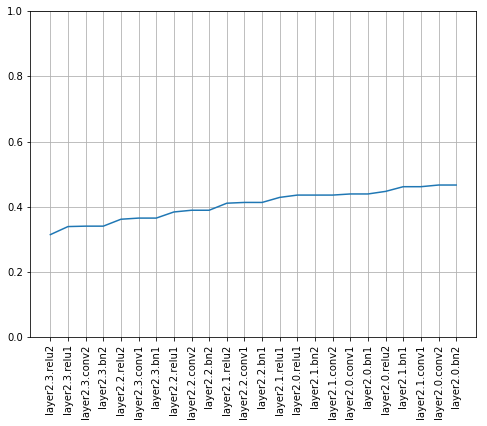

resnet34-plain-vs-resnet34-plain2layer2


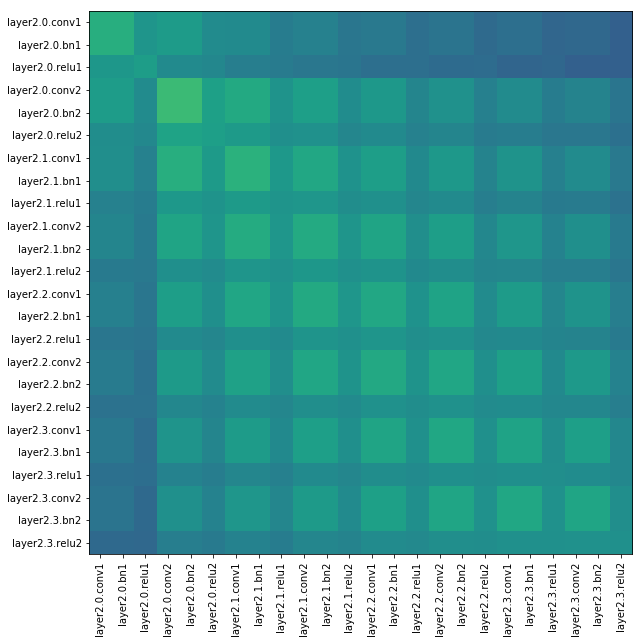

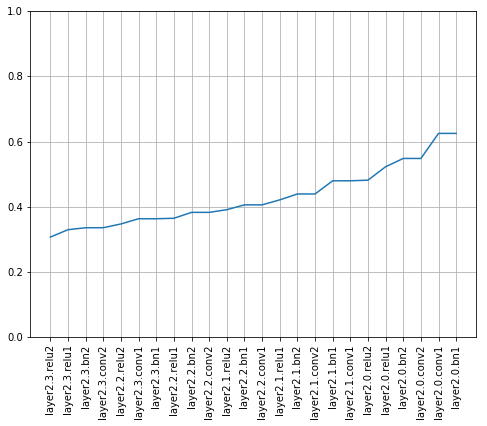

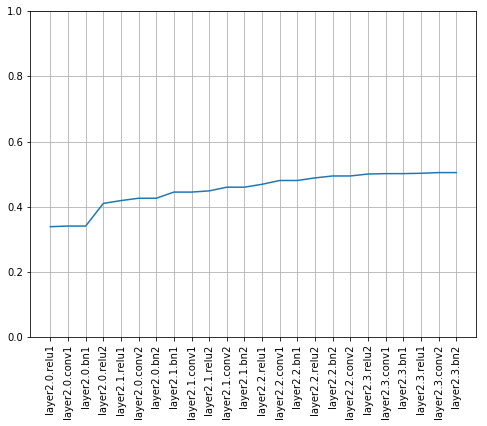

In [32]:
_layer = "layer2"
for key1, key2 in combinations(trackers.keys(), 2):
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    print(comb_key)
    table = tables[comb_key].copy()

    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    tracker2 = trackers[key2]
    layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())

    show_pack(table, layers1, layers2)

resnet34-skip-vs-resnet34-skip2layer3


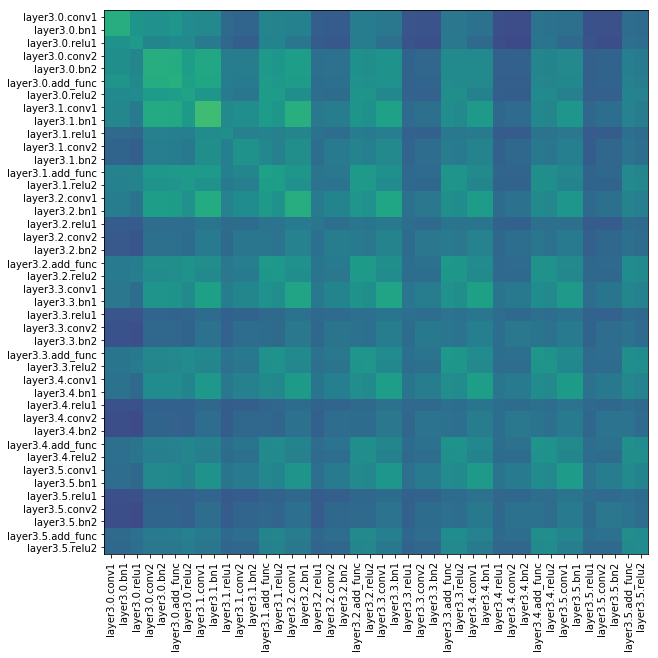

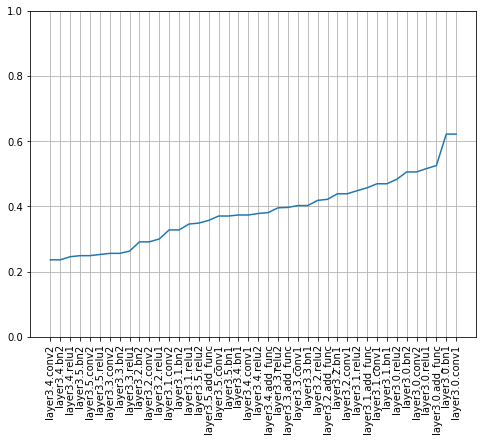

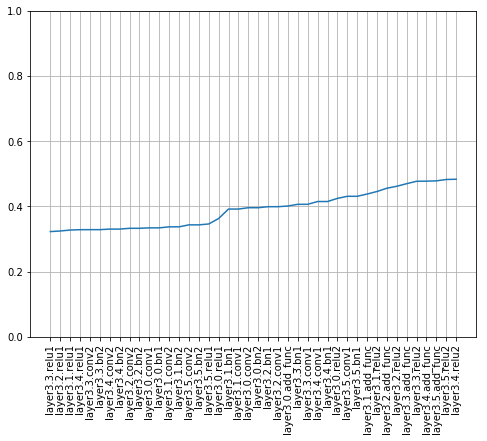

resnet34-skip-vs-resnet34-plainlayer3


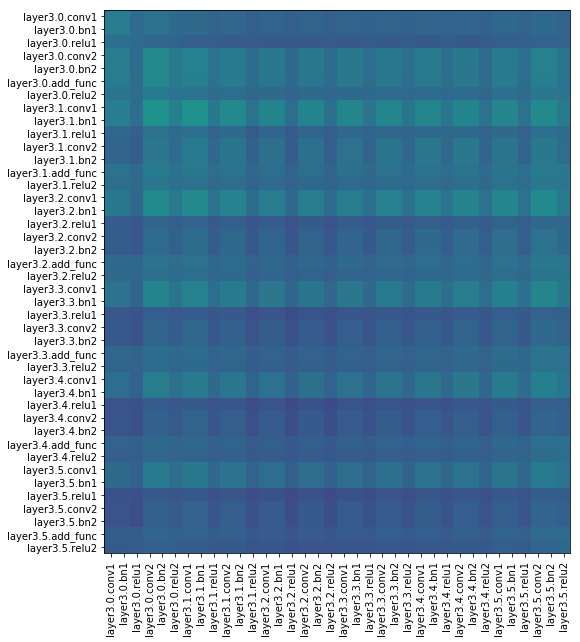

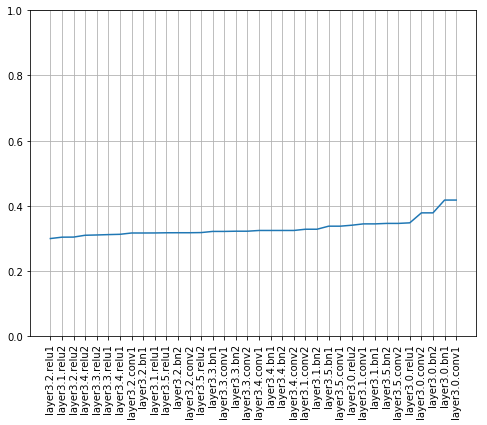

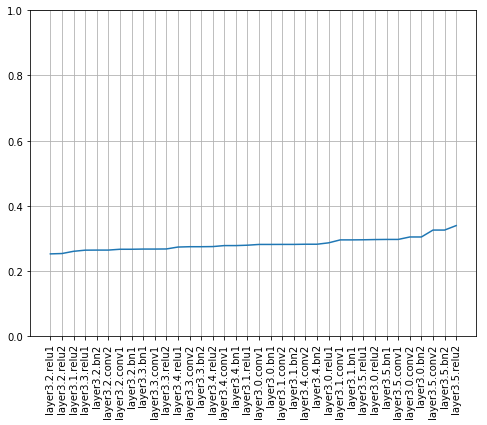

resnet34-skip-vs-resnet34-plain2layer3


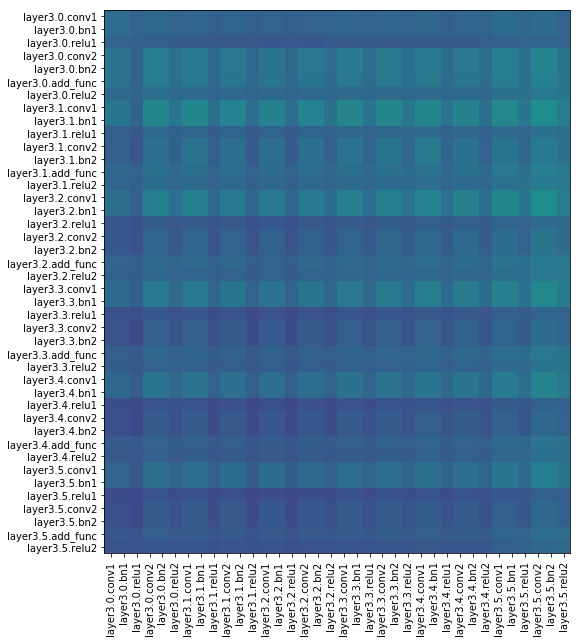

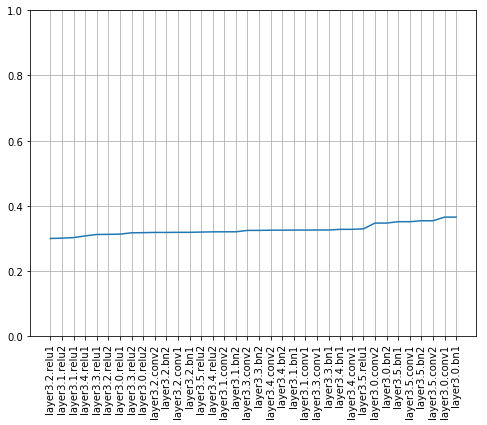

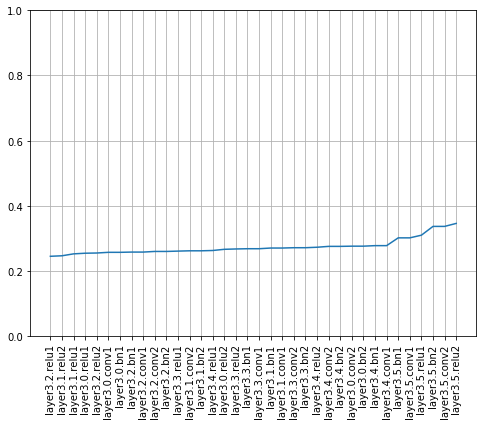

resnet34-skip2-vs-resnet34-plainlayer3


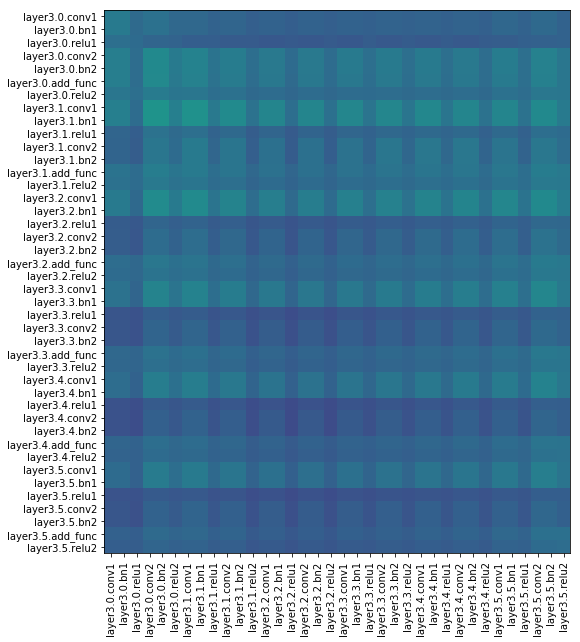

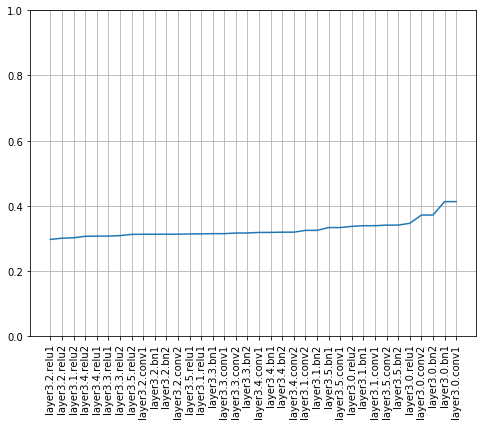

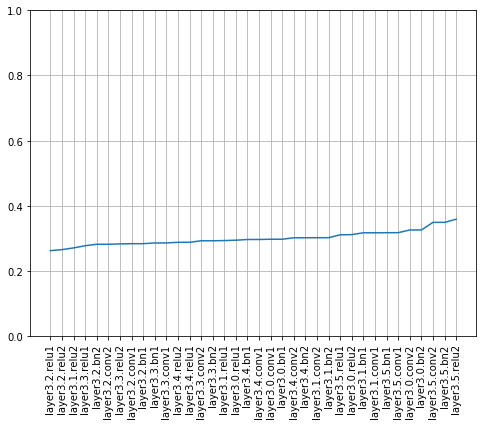

resnet34-skip2-vs-resnet34-plain2layer3


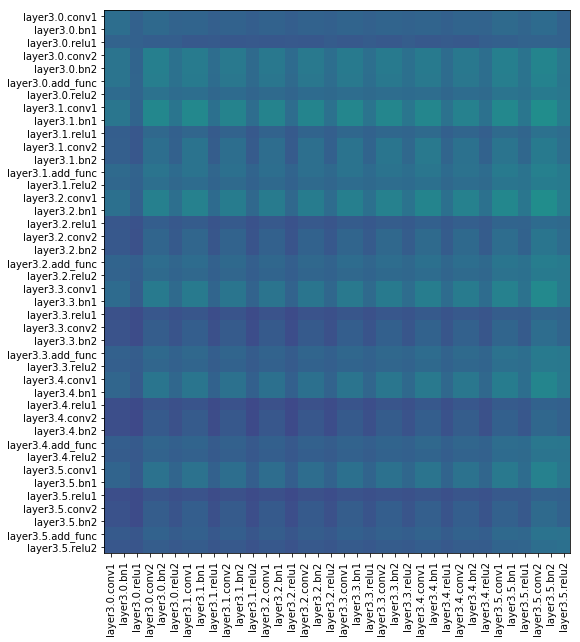

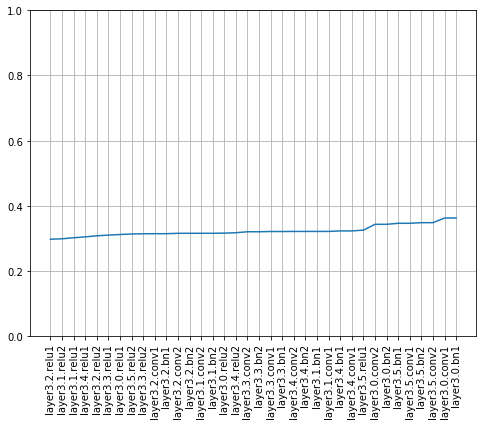

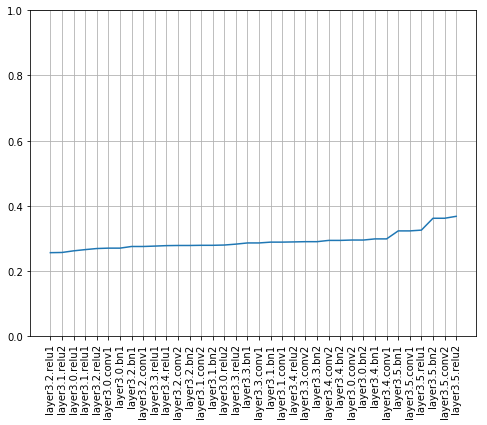

resnet34-plain-vs-resnet34-plain2layer3


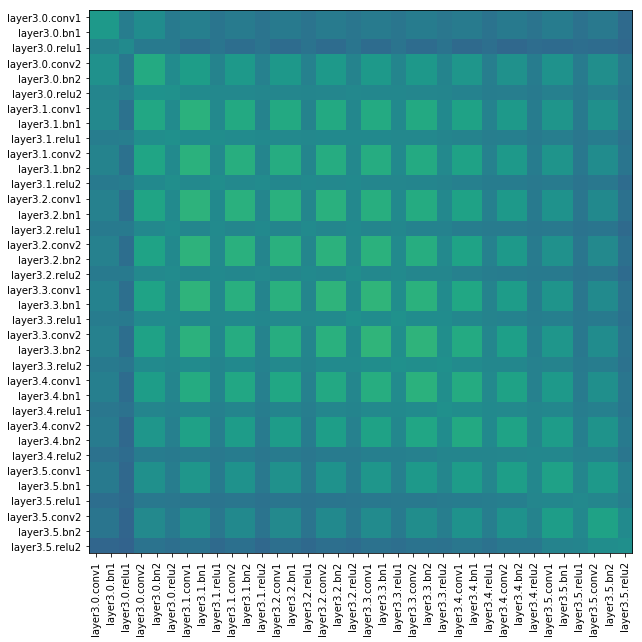

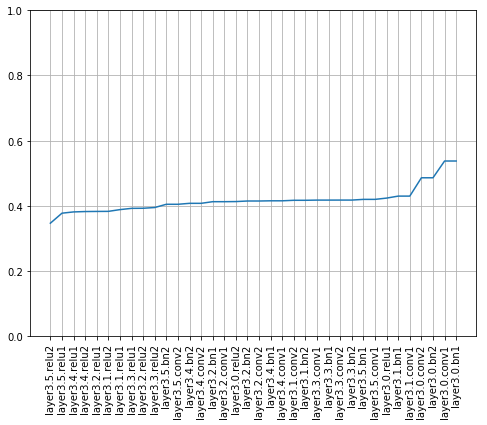

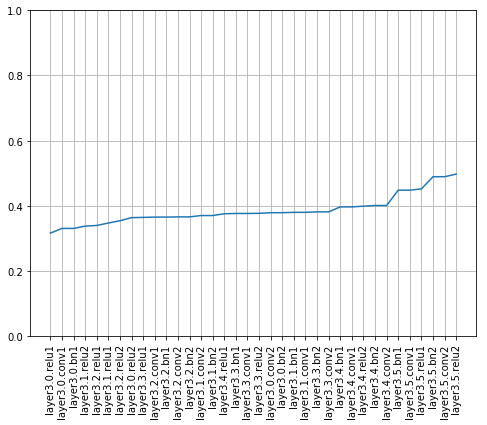

In [33]:
_layer = "layer3"
for key1, key2 in combinations(trackers.keys(), 2):
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    print(comb_key)
    table = tables[comb_key].copy()

    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    tracker2 = trackers[key2]
    layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())

    show_pack(table, layers1, layers2)

resnet34-skip-vs-resnet34-skip2layer4


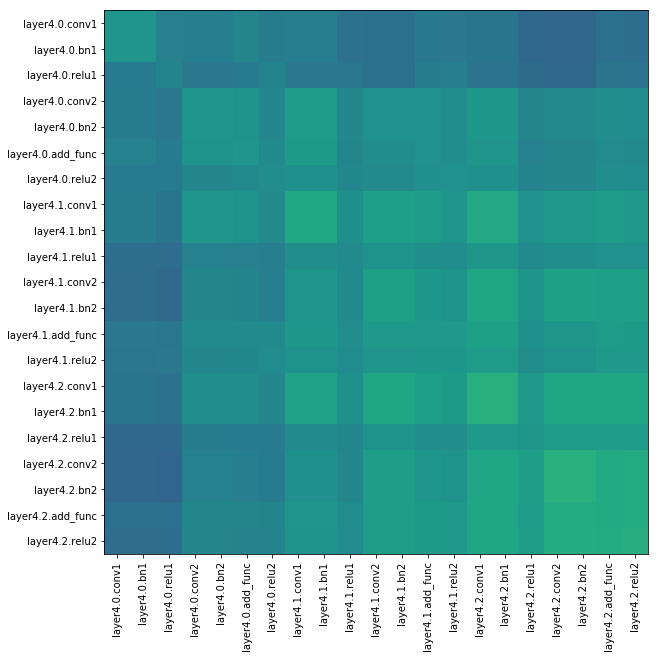

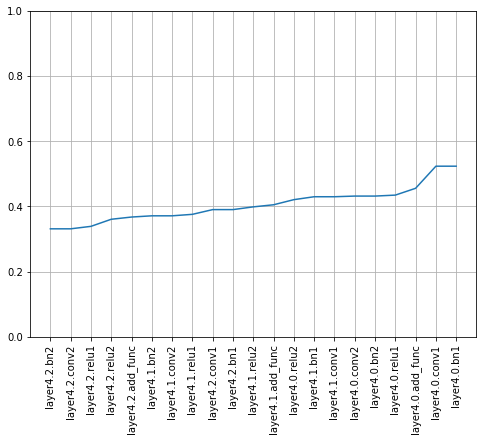

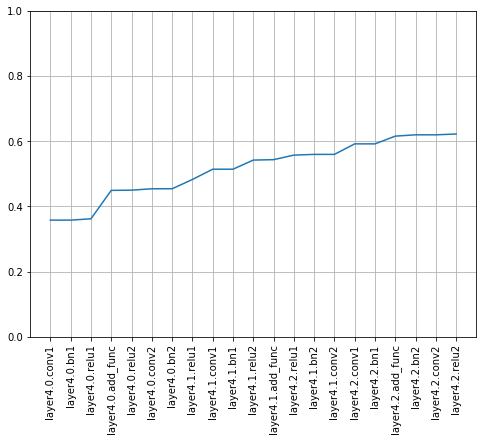

resnet34-skip-vs-resnet34-plainlayer4


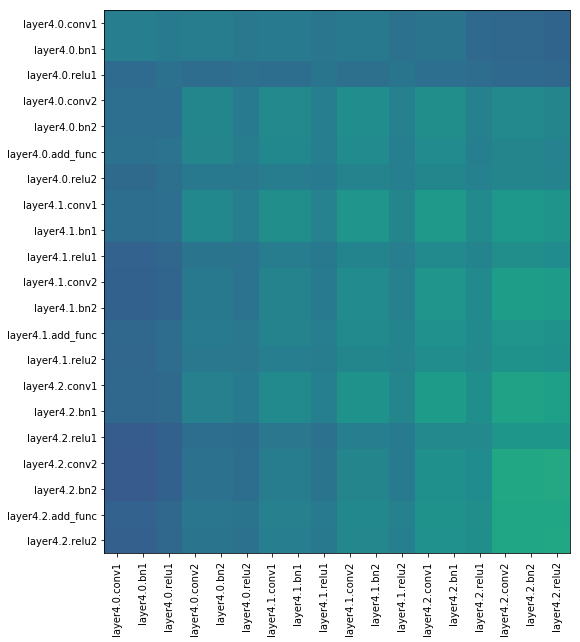

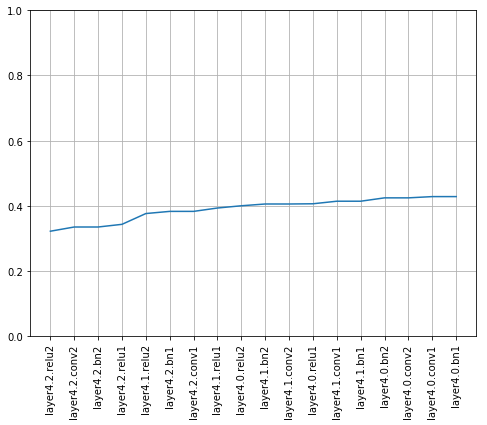

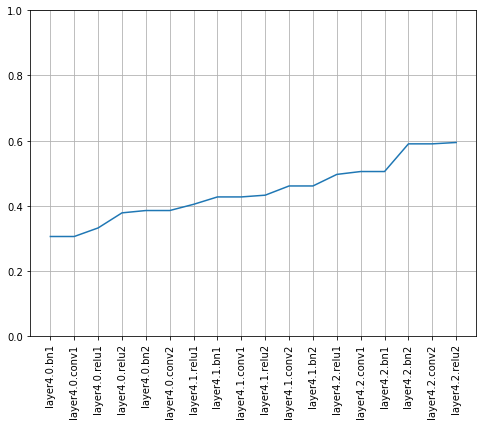

resnet34-skip-vs-resnet34-plain2layer4


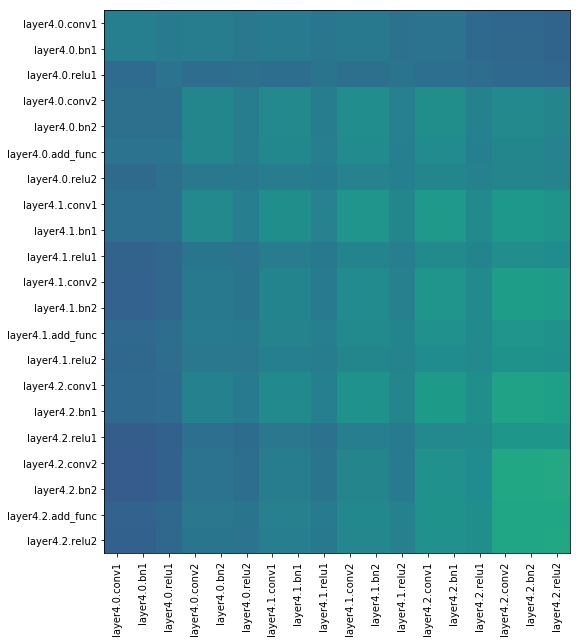

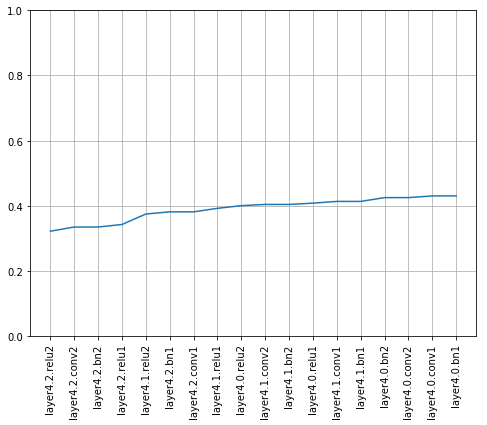

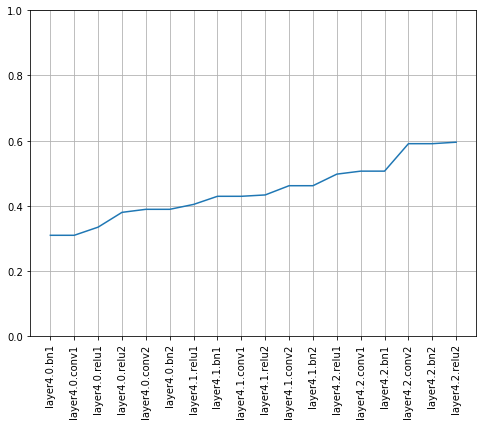

resnet34-skip2-vs-resnet34-plainlayer4


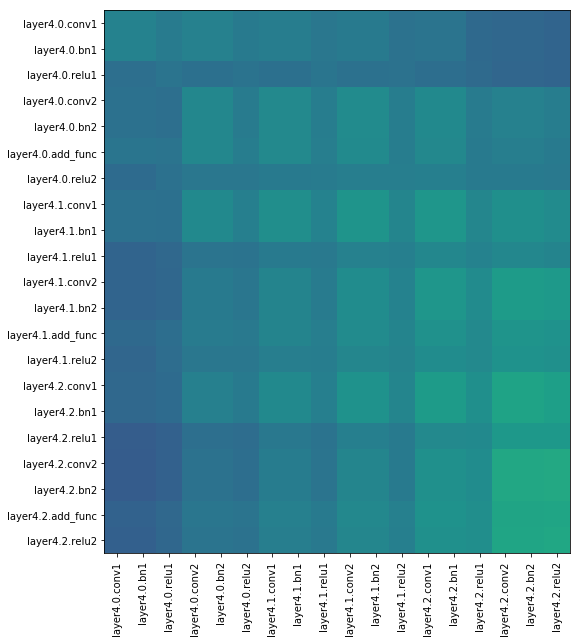

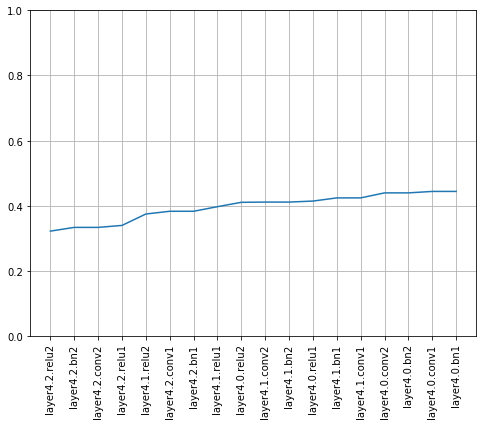

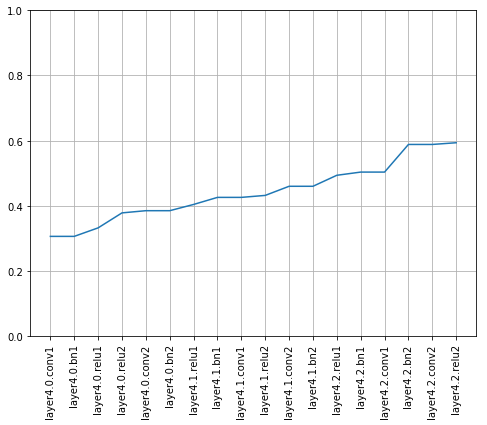

resnet34-skip2-vs-resnet34-plain2layer4


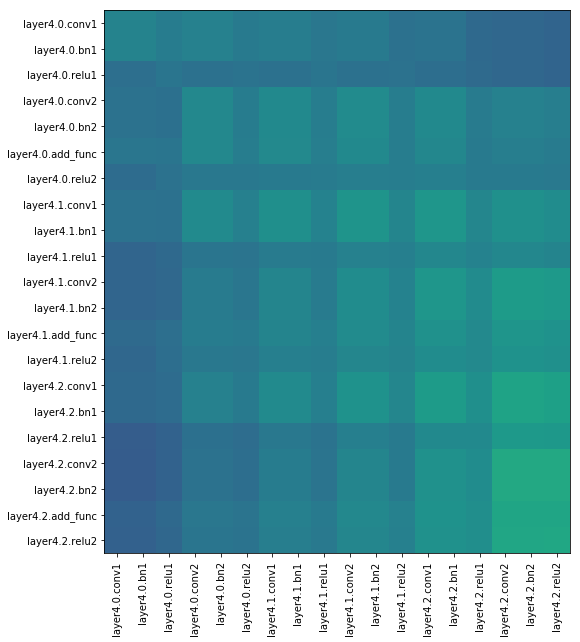

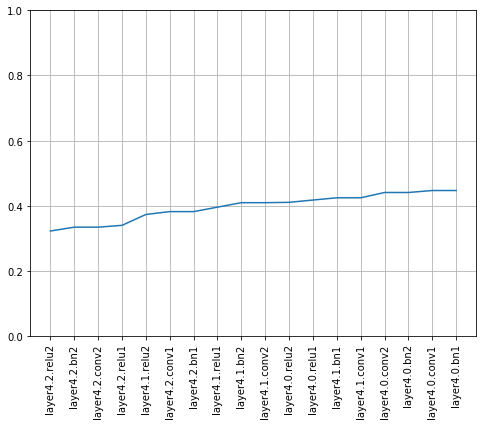

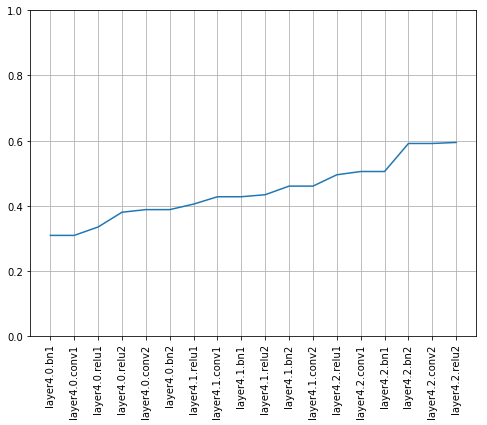

resnet34-plain-vs-resnet34-plain2layer4


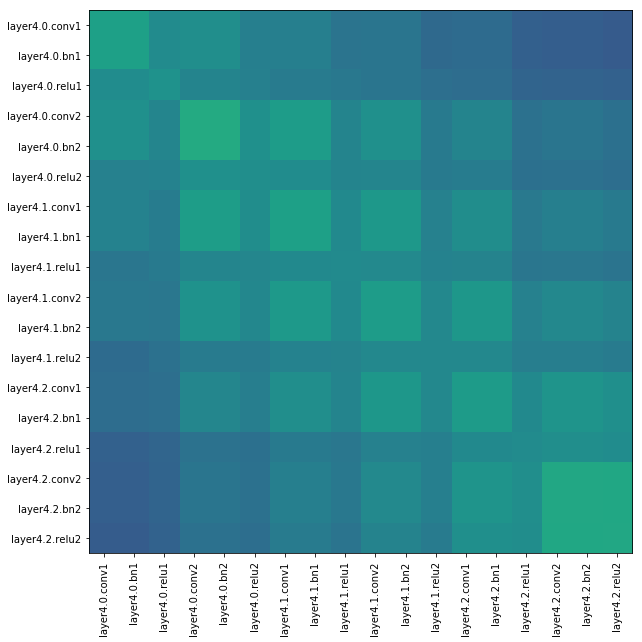

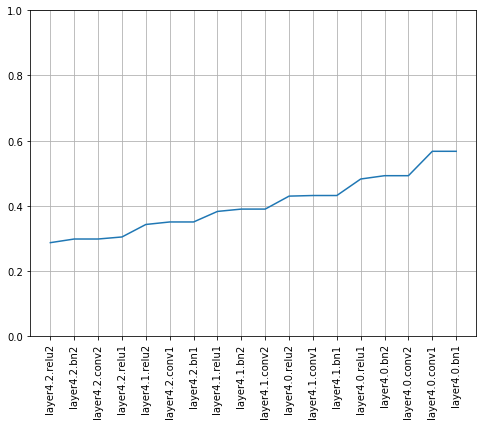

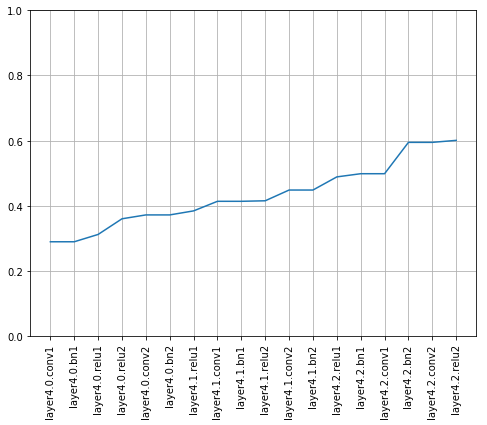

In [34]:
_layer = "layer4"
for key1, key2 in combinations(trackers.keys(), 2):
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    print(comb_key)
    table = tables[comb_key].copy()

    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    tracker2 = trackers[key2]
    layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())

    show_pack(table, layers1, layers2)

In [35]:
tables.keys()

dict_keys(['resnet34-skip-vs-resnet34-skip2layer1', 'resnet34-skip-vs-resnet34-plainlayer1', 'resnet34-skip-vs-resnet34-plain2layer1', 'resnet34-skip2-vs-resnet34-plainlayer1', 'resnet34-skip2-vs-resnet34-plain2layer1', 'resnet34-plain-vs-resnet34-plain2layer1', 'resnet34-skip-vs-resnet34-skip2layer2', 'resnet34-skip-vs-resnet34-plainlayer2', 'resnet34-skip-vs-resnet34-plain2layer2', 'resnet34-skip2-vs-resnet34-plainlayer2', 'resnet34-skip2-vs-resnet34-plain2layer2', 'resnet34-plain-vs-resnet34-plain2layer2', 'resnet34-skip-vs-resnet34-skip2layer3', 'resnet34-skip-vs-resnet34-plainlayer3', 'resnet34-skip-vs-resnet34-plain2layer3', 'resnet34-skip2-vs-resnet34-plainlayer3', 'resnet34-skip2-vs-resnet34-plain2layer3', 'resnet34-plain-vs-resnet34-plain2layer3', 'resnet34-skip-vs-resnet34-skip2layer4', 'resnet34-skip-vs-resnet34-plainlayer4', 'resnet34-skip-vs-resnet34-plain2layer4', 'resnet34-skip2-vs-resnet34-plainlayer4', 'resnet34-skip2-vs-resnet34-plain2layer4', 'resnet34-plain-vs-resne

In [57]:
key1 = "resnet34-skip"
key2 = "resnet34-skip2"
data = []
layers = []
for _layer in ["layer1", "layer2", "layer3", "layer4"]:
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    layers.extend(layers1)
    tmp = tables[comb_key].copy()
    data.append(tmp[range(tmp.shape[0]), range(tmp.shape[1])])
data = np.concatenate(data)

In [58]:
data_skip = data.copy()
layers_skip = layers

In [59]:
len(layers)

113

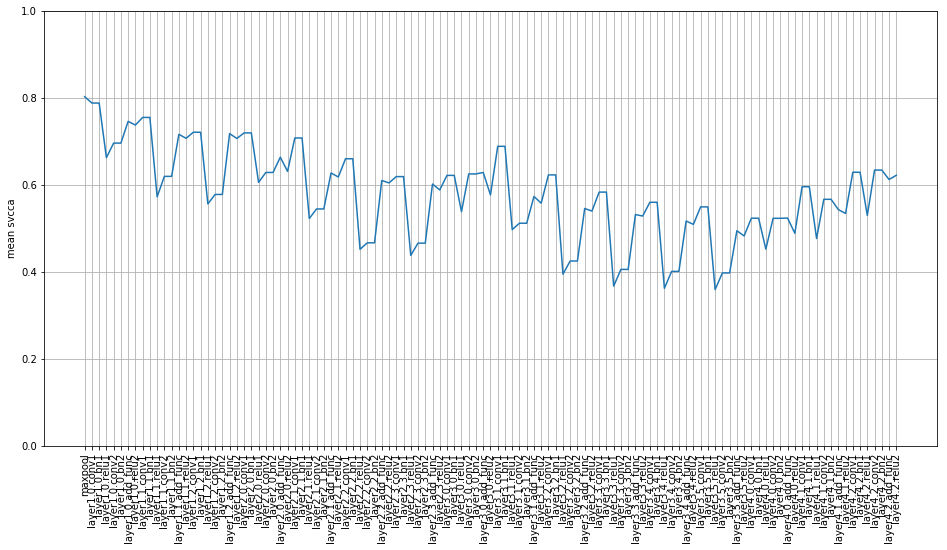

In [60]:
plt.figure(figsize=(16, 8))
plt.plot(data)
plt.ylim(0, 1)
plt.xticks(range(len(layers)), layers, rotation=90)
plt.ylabel("mean svcca")
plt.grid()
plt.show()

In [61]:
key1 = "resnet34-plain"
key2 = "resnet34-plain2"
data = []
layers = []
for _layer in ["layer1", "layer2", "layer3", "layer4"]:
    comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
    tracker1 = trackers[key1]
    layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
    layers.extend(layers1)
    tmp = tables[comb_key].copy()
    data.append(tmp[range(tmp.shape[0]), range(tmp.shape[1])])
data = np.concatenate(data)

In [62]:
data_plain = data.copy()
layers_plain = layers

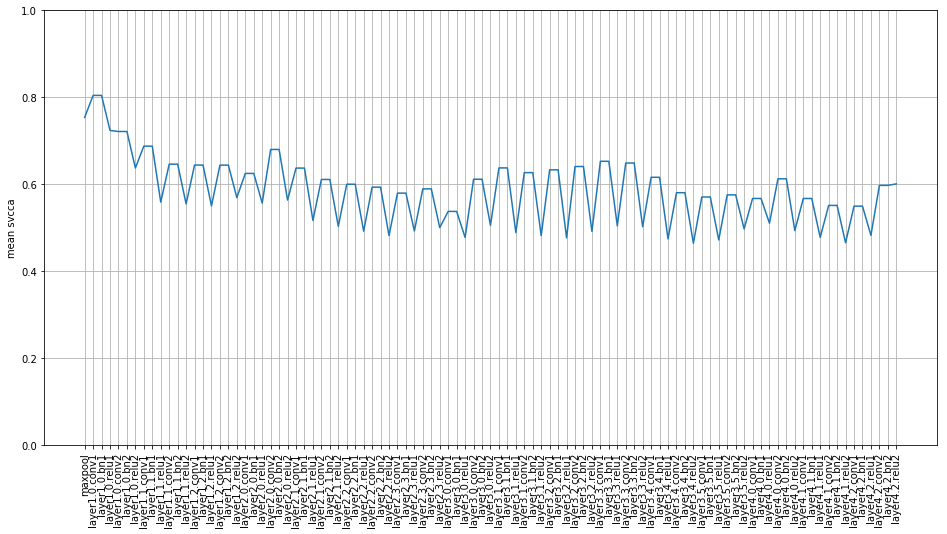

In [63]:
plt.figure(figsize=(16, 8))
plt.plot(data)
plt.ylim(0, 1)
plt.xticks(range(len(layers)), layers, rotation=90)
plt.ylabel("mean svcca")
plt.grid()
plt.show()

In [64]:
len(layers_skip), len(layers_plain)

(113, 97)

In [67]:
layers_skip.index("maxpool")

0

In [68]:
index = np.asarray([layers_skip.index(l) for l in layers_plain])

In [69]:
data_p = np.zeros_like(data_skip)
data_p[index] = data_plain

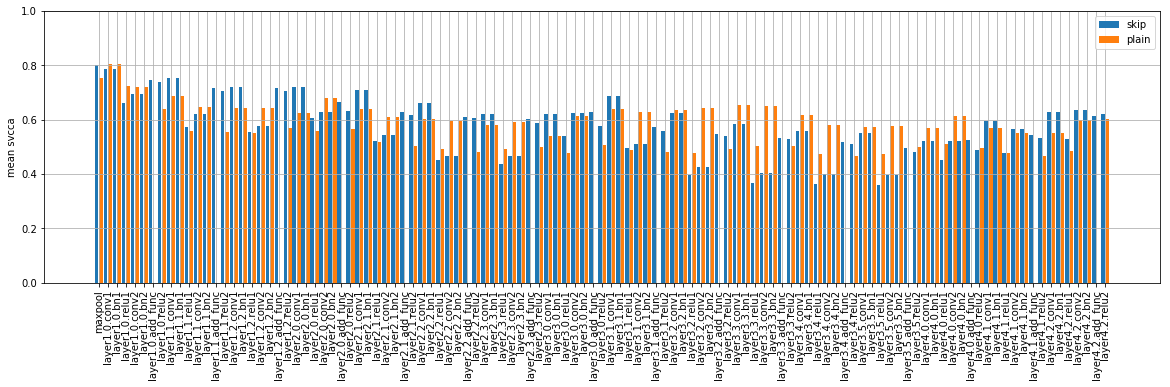

In [79]:
plt.figure(figsize=(20, 5))

width = 0.5
plt.bar(np.arange(len(layers_skip)) - width / 2, data_skip, width=width*0.8, color="tab:blue", label="skip")
plt.bar(np.arange(len(layers_skip)) + width / 2, data_p, width=width*0.8, color="tab:orange", label="plain")

plt.ylim(0, 1)
plt.xticks(range(len(layers_skip)), layers_skip, rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

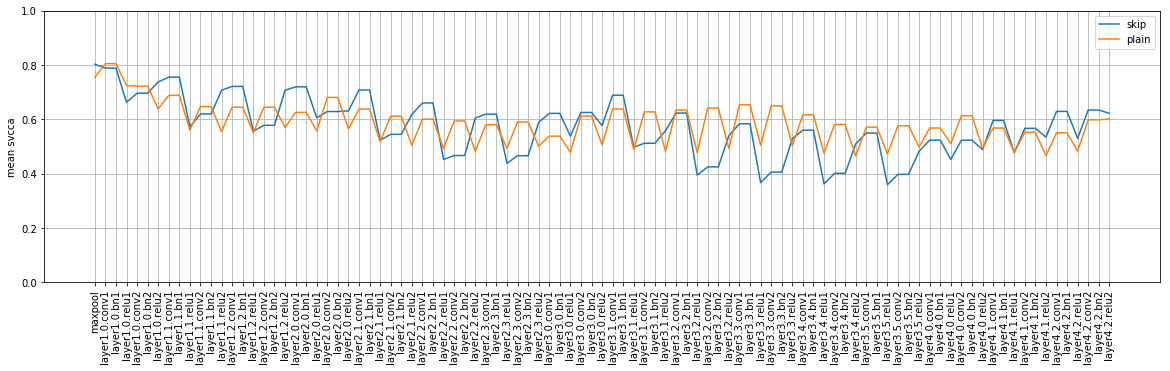

In [80]:
plt.figure(figsize=(20, 5))
plt.plot(data_skip[index], color="tab:blue", label="skip")
plt.plot(data_p[index], color="tab:orange", label="plain")


plt.ylim(0, 1)
plt.xticks(range(len(layers_plain)), layers_plain, rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

In [83]:
layers_skip = np.asarray(layers_skip)

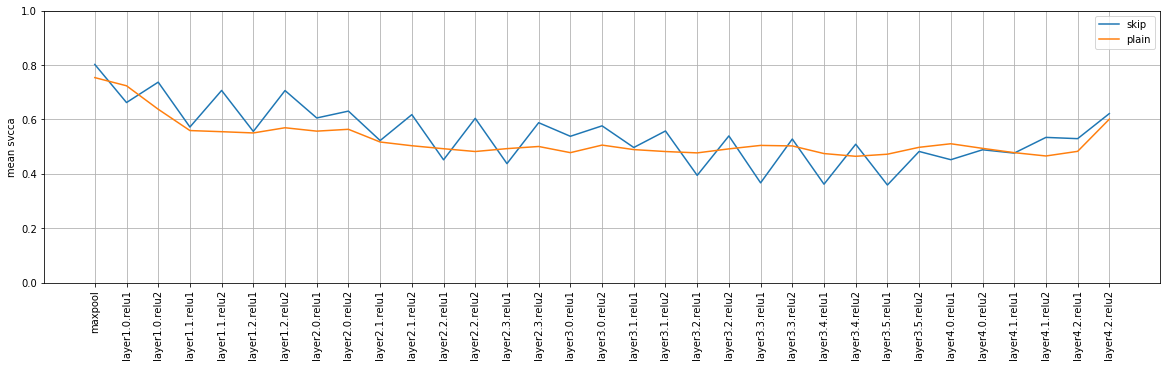

In [89]:
filter_index = [np.where(layers_skip == l)[0][0] for l in layers_skip if ("relu " in l) or (l == "maxpool")]

plt.figure(figsize=(20, 5))
plt.plot(data_skip[filter_index], color="tab:blue", label="skip")
plt.plot(data_p[filter_index], color="tab:orange", label="plain")


plt.ylim(0, 1)
plt.xticks(range(len(layers_skip[filter_index])), layers_skip[filter_index], rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

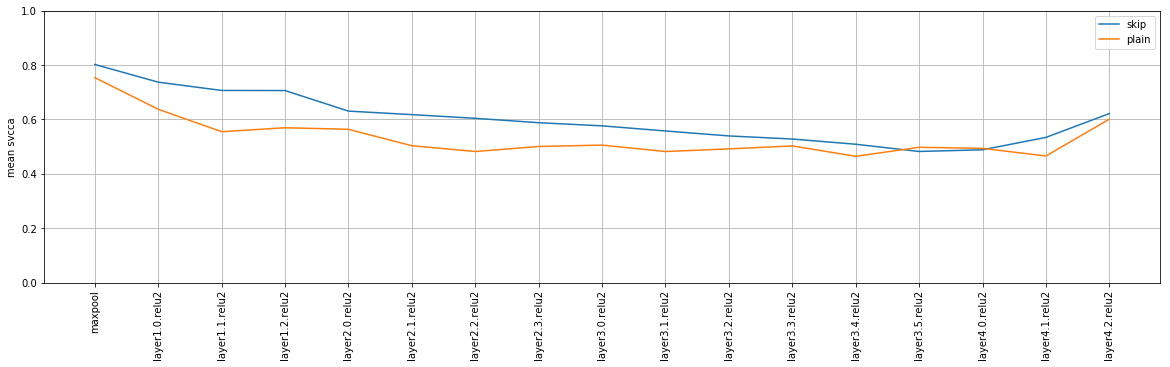

In [88]:
filter_index = [np.where(layers_skip == l)[0][0] for l in layers_skip if ("relu2" in l) or (l == "maxpool")]

plt.figure(figsize=(20, 5))
plt.plot(data_skip[filter_index], color="tab:blue", label="skip")
plt.plot(data_p[filter_index], color="tab:orange", label="plain")


plt.ylim(0, 1)
plt.xticks(range(len(layers_skip[filter_index])), layers_skip[filter_index], rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

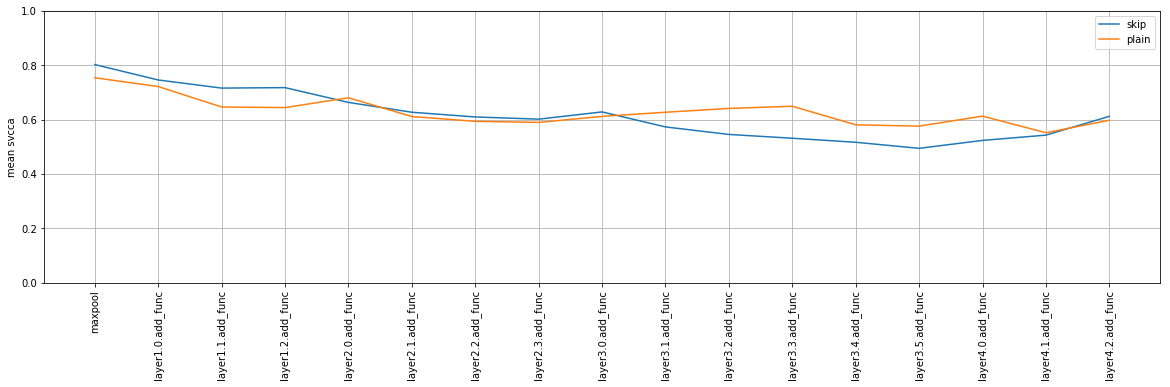

In [102]:
filter_index = [np.where(layers_skip == l)[0][0] for l in layers_skip if ("add_func" in l) or (l == "maxpool")]
filter_index_1 = np.maximum(np.asarray(filter_index) -1, 0)
plt.figure(figsize=(20, 5))
plt.plot(data_skip[filter_index], color="tab:blue", label="skip")
plt.plot(data_p[filter_index_1], color="tab:orange", label="plain")

plt.ylim(0, 1)
plt.xticks(range(len(layers_skip[filter_index])), layers_skip[filter_index], rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

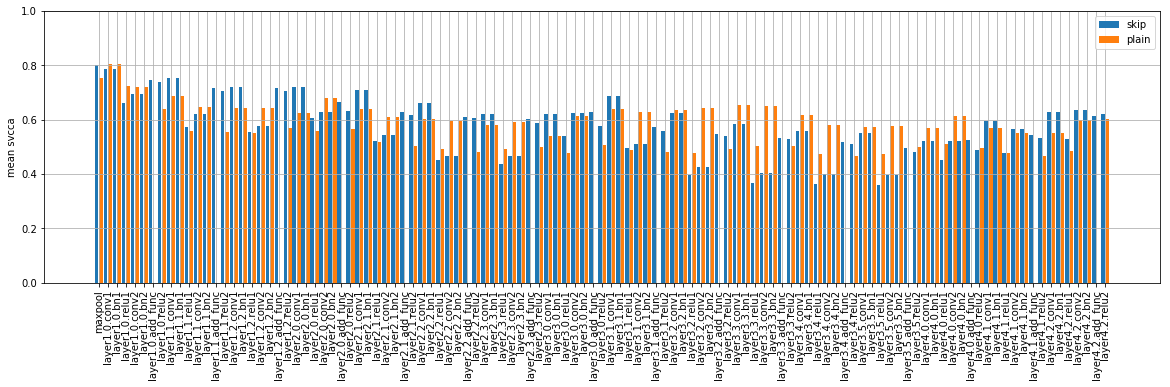

In [79]:
plt.figure(figsize=(20, 5))
width = 0.5
plt.bar(np.arange(len(layers_skip)) - width / 2, data_skip, width=width*0.8, color="tab:blue", label="skip")
plt.bar(np.arange(len(layers_skip)) + width / 2, data_p, width=width*0.8, color="tab:orange", label="plain")

plt.ylim(0, 1)
plt.xticks(range(len(layers_skip)), layers_skip, rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

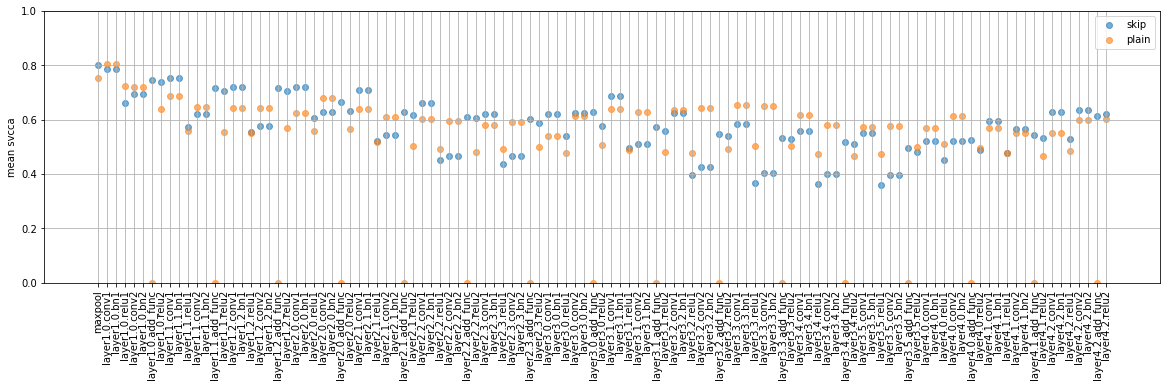

In [104]:
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(layers_skip)), data_skip, color="tab:blue", label="skip", alpha=0.6)
plt.scatter(np.arange(len(layers_skip)), data_p, color="tab:orange", label="plain", alpha=0.6)

plt.ylim(0, 1)
plt.xticks(range(len(layers_skip)), layers_skip, rotation=90)
plt.ylabel("mean svcca")
plt.legend()
plt.grid()
plt.show()

In [105]:
tables.keys()

dict_keys(['resnet34-skip-vs-resnet34-skip2layer1', 'resnet34-skip-vs-resnet34-plainlayer1', 'resnet34-skip-vs-resnet34-plain2layer1', 'resnet34-skip2-vs-resnet34-plainlayer1', 'resnet34-skip2-vs-resnet34-plain2layer1', 'resnet34-plain-vs-resnet34-plain2layer1', 'resnet34-skip-vs-resnet34-skip2layer2', 'resnet34-skip-vs-resnet34-plainlayer2', 'resnet34-skip-vs-resnet34-plain2layer2', 'resnet34-skip2-vs-resnet34-plainlayer2', 'resnet34-skip2-vs-resnet34-plain2layer2', 'resnet34-plain-vs-resnet34-plain2layer2', 'resnet34-skip-vs-resnet34-skip2layer3', 'resnet34-skip-vs-resnet34-plainlayer3', 'resnet34-skip-vs-resnet34-plain2layer3', 'resnet34-skip2-vs-resnet34-plainlayer3', 'resnet34-skip2-vs-resnet34-plain2layer3', 'resnet34-plain-vs-resnet34-plain2layer3', 'resnet34-skip-vs-resnet34-skip2layer4', 'resnet34-skip-vs-resnet34-plainlayer4', 'resnet34-skip-vs-resnet34-plain2layer4', 'resnet34-skip2-vs-resnet34-plainlayer4', 'resnet34-skip2-vs-resnet34-plain2layer4', 'resnet34-plain-vs-resne

In [127]:
_keys = [
    ("resnet34-skip", "resnet34-plain"),
    ("resnet34-skip", "resnet34-plain2"),
    ("resnet34-skip2", "resnet34-plain"),
    ("resnet34-skip2", "resnet34-plain2"),
]
datas = []
for key1, key2 in _keys:
    data = []
    layers = []
    for _layer in ["layer1", "layer2", "layer3", "layer4"]:
        comb_key = "{}-vs-{}{}".format(key1, key2, _layer)
        tracker1 = trackers[key1]
        layers1 = get_layers_keys(_layer, trackers[key1].fmap_pool.keys())
        tracker2 = trackers[key2]
        layers2 = get_layers_keys(_layer, trackers[key2].fmap_pool.keys())
        tmp = tables[comb_key].copy()
        if "skip" in key1:
            index = np.asarray([layers1.index(l) for l in layers2])
            layers.extend(np.asarray(layers1)[index])
            data.append(tmp[index, range(len(layers2))])
        else:
            index = np.asarray([layers2.index(l) for l in layers1])
            layers.extend(np.asarray(layers2)[index])
            data.append(tmp[range(len(layers1)), index])
    data = np.concatenate(data)
    datas.append(data)
datas = np.asarray(datas)

In [129]:
datas.shape

(4, 97)

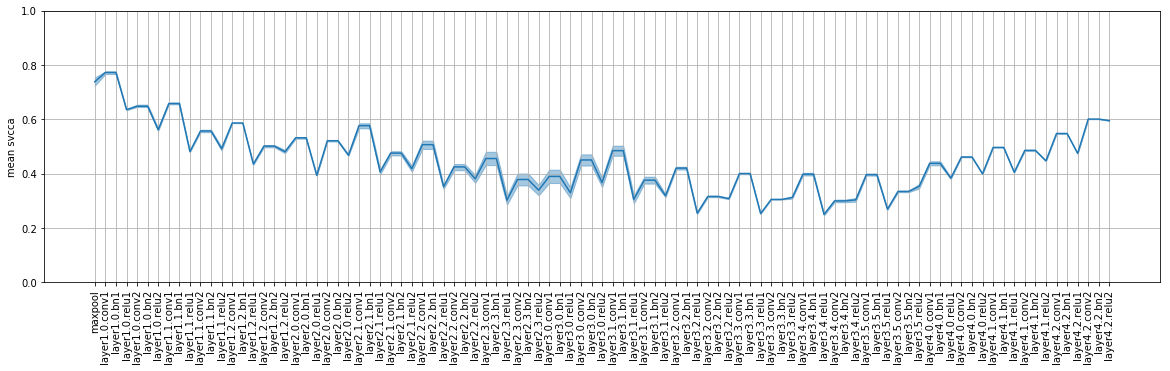

In [133]:
# np_data = np.mean(datas, axis=0).copy()
np_data = np.percentile(datas, 50, axis=0)
np_data25 = np.percentile(datas, 25, axis=0)
np_data75 = np.percentile(datas, 75, axis=0)

np_layers = np.asarray(layers)
plt.figure(figsize=(20, 5))
x = np.arange(len(np_layers))
# plt.scatter(x, np_data, color="tab:blue")
plt.plot(x, np_data, color="tab:blue")

plt.fill_between(x, np_data25, np_data75, color="tab:blue", alpha=0.4)

plt.ylim(0, 1)
plt.xticks(range(len(np_layers)), np_layers, rotation=90)
plt.ylabel("mean svcca")
plt.grid()
plt.show()